# TripAdvisor Hotel Reviews Sentiment Analysis Project

## BiLSTM

This Jupyter notebook performs sentiment analysis on a TripAdvisor Hotel Reviews dataset using BiLSTM.

###Install needed libraries

In [ ]:
!pip install huggingface_hub

In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 44.5 MB/s eta 0:00:00


### Import needed modules and libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from gensim.utils import simple_preprocess
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from huggingface_hub import hf_hub_download
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

### Load data

In [ ]:

#Load the TripAdvisor dataset from Hugging Face
df = pd.read_parquet("hf://datasets/jniimi/tripadvisor-review-rating/data/train-00000-of-00001.parquet")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#Add another column called "sentiment" which will contain the negative,
#neutral or positive sentiment depending on the "overall" rating.
df['sentiment'] = df['overall'].apply(lambda x: 0 if x == 1 else 0 if x == 2
                                      else 1 if x == 3 else 2)

In [ ]:
#Filter dataframe to columns of interest
df2 = df[["sentiment","review","overall"]]
df2

,sentiment,review,overall
0,2,Really excellent Hilton\nStayed here on busine...,5.0
1,2,Exceptional service and comfort\nSpent two nig...,5.0
2,2,Nice room and five star service\nGreat place f...,5.0
3,2,"BRILLIANT hotel, my #1 Chicago pick for busine...",5.0
4,2,Convenient and comfortable\nBEST. BREAKFAST. E...,5.0
...,...,...,...
201290,2,Great find in cool neighborhood\nAlthough a na...,4.0
201291,2,Exceptional Service and great room\nI have sta...,5.0
201292,0,Beware of the Rip Off!\nI received a call for ...,2.0
201293,2,It Deserves the Rating\nI really like Kimptons...,5.0


### BiLSTM Model

In [ ]:
df_BiLSTM = df2.copy()

#Perform a simple preprocessing of the reviews
df_BiLSTM["processed_review"] = df_BiLSTM["review"].apply(lambda x: " ".join(simple_preprocess(x)))




In [ ]:
#Fit Tokenizer on the reviews
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_BiLSTM["processed_review"])

In [ ]:
#Separate into training, validation and final testing data
X_train_BiLSTM, temp_reviews, Y_train_BiLSTM, temp_labels = train_test_split(df_BiLSTM["processed_review"], df_BiLSTM["sentiment"],
                                                    train_size=0.70, test_size=0.30,
                                                    stratify=df_BiLSTM["sentiment"], random_state=42)

X_test_BiLSTM, final_test_reviews, Y_test_BiLSTM, final_test_labels = train_test_split(
    temp_reviews, temp_labels, stratify=temp_labels, test_size=0.50, random_state=42
)

In [ ]:
#Function to add padding to the reviews
def add_padding(X_BiLSTM, maxlen):
  return pad_sequences(X_BiLSTM, padding="post", maxlen=maxlen)

In [ ]:
#Convert reviews to sequences
X_train_BiLSTM = tokenizer.texts_to_sequences(X_train_BiLSTM)
X_test_BiLSTM = tokenizer.texts_to_sequences(X_test_BiLSTM)
final_test_reviews = tokenizer.texts_to_sequences(final_test_reviews)

#Pad reviews to maximum length of 400
maxlen = 400
X_train_BiLSTM = add_padding(X_train_BiLSTM, maxlen)
X_test_BiLSTM = add_padding(X_test_BiLSTM, maxlen)
final_test_reviews = add_padding(final_test_reviews, maxlen)

In [ ]:
#Download the pretrained Glove embedding model
glove_model_path = hf_hub_download("fse/glove-wiki-gigaword-300", "glove-wiki-gigaword-300.model")
glove_vectors_path = hf_hub_download("fse/glove-wiki-gigaword-300", "glove-wiki-gigaword-300.model.vectors.npy")

# Load the pretrained GloVe model
glove_pretrained_model = KeyedVectors.load(glove_model_path, mmap='r')

In [ ]:
#Get number of unique words in the reviews
vocab_length = len(tokenizer.word_index.keys())
#Add 1 to account for words that are not in pretrained word embeddings
vocab_length += 1

size_glove = glove_pretrained_model.vector_size

#Initialize embedding matrix
embedding_matrix = np.full((vocab_length, glove_pretrained_model.vector_size), 0)

#If the word from the tokenizer.word_index exists in the GloVe pretrained word embeddings,
#then assign that at the appropriate index for embedding_matrix. If not, then
#generate a random vector of the same shape
for key in tokenizer.word_index.keys():
  if key not in glove_pretrained_model:
    embedding_matrix[tokenizer.word_index[key]] = np.random.normal(scale=0.6, size=(glove_pretrained_model.vector_size,))
  else:
    embedding_matrix[tokenizer.word_index[key]] = glove_pretrained_model[key]

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


In [ ]:
X_train_BiLSTM_tensor = torch.tensor(X_train_BiLSTM, dtype=torch.long)
Y_train_BiLSTM_tensor = torch.tensor(Y_train_BiLSTM.to_numpy(), dtype=torch.long)

X_test_BiLSTM_tensor = torch.tensor(X_test_BiLSTM, dtype=torch.long)
Y_test_BiLSTM_tensor = torch.tensor(Y_test_BiLSTM.to_numpy(), dtype=torch.long)

X_final_test_BiLSTM_tensor = torch.tensor(final_test_reviews, dtype=torch.long)
Y_final_test_BiLSTM_tensor = torch.tensor(final_test_labels.to_numpy(), dtype=torch.long)

#Create the dataset instances
train_dataset = TensorDataset(X_train_BiLSTM_tensor, Y_train_BiLSTM_tensor)
test_dataset = TensorDataset(X_test_BiLSTM_tensor, Y_test_BiLSTM_tensor)
final_test_dataset = TensorDataset(X_final_test_BiLSTM_tensor, Y_final_test_BiLSTM_tensor)

#Create the DataLoader objects
X_train_BiLSTM_load = DataLoader(train_dataset, batch_size=32)
X_test_BiLSTM_load = DataLoader(test_dataset, batch_size=32)
final_test_BiLSTM_load = DataLoader(final_test_dataset, batch_size=32)

In [ ]:

class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size , num_classes, lstm_layers,
               bidirectional, batch_first, dropout_rate):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.lstm_layers = lstm_layers
        self.bidirectional = bidirectional
        self.dropout_rate = dropout_rate
        self.batch_first = batch_first
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.lstm = nn.LSTM(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=lstm_layers,
                            bias=True,
                            batch_first=self.batch_first,
                            dropout=self.dropout_rate,
                            bidirectional=self.bidirectional)

        self.linear = nn.Linear(hidden_size * 2, self.num_classes)


    def forward(self, reviews):
        embedded = self.embedding(reviews)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        dropped = F.dropout(hidden, p=self.dropout_rate, training=self.training)
        result = self.linear(dropped)
        return result


In [ ]:
#Model Parameters
embedding_dim = embedding_matrix.shape[1]
hidden_size = 128
lstm_layers = 2
num_classes = 3
bidirectional = True
dropout_rate = 0.4
batch_first = True


In [ ]:
#Create model
model = BiLSTM(embedding_dim=embedding_dim,hidden_size=hidden_size, num_classes=num_classes,
               lstm_layers=lstm_layers, batch_first=batch_first,
               bidirectional=bidirectional, dropout_rate=dropout_rate)

#If GPU is available, use GPU
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

model.to(device)

BiLSTM(
  (embedding): Embedding(94314, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (linear): Linear(in_features=256, out_features=3, bias=True)
)

In [ ]:
#Add Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#Set criterion to Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epoch = 5

highest_f1_score = 0

#Train the model
for epoch in range(num_epoch):
    model.train()

    loss_per_batch = 0

    for batch_idx, (reviews, labels) in enumerate(X_train_BiLSTM_load):
        reviews = reviews.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(reviews)

        #Compute loss
        loss = criterion(outputs, labels)

        #Backpropragation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_per_batch += loss.item()

    avg_loss = loss_per_batch / len(X_train_BiLSTM_load)

    print("Epoch ", epoch + 1, ", Loss: ", avg_loss)


    predictions = []
    correct_labels = []

    #Validate model
    model.eval()
    with torch.no_grad():
      for batch_idx, (reviews, labels) in enumerate(X_test_BiLSTM_load):
        reviews = reviews.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(reviews)

        #Get predictions
        preds = torch.argmax(outputs, dim=1)
        preds = preds.cpu().tolist()
        predictions.extend(preds)

        correct_labels.extend(labels.cpu().tolist())

    macro_f1_score = f1_score(correct_labels, predictions, average='macro')
    print("Epoch ", epoch + 1, ", Macro F1 Score: ", macro_f1_score)

    #Save best model based on highest macro F1 score
    if macro_f1_score > highest_f1_score:
      highest_f1_score = macro_f1_score
      torch.save(model.state_dict(), "best_BiLSTM_model.pt")



Epoch  1 , Loss:  0.3607830617959179
Epoch  1 , Macro F1 Score:  0.7727429896696857
Epoch  2 , Loss:  0.26156833662070356
Epoch  2 , Macro F1 Score:  0.777678790672527
Epoch  3 , Loss:  0.21576097609367828
Epoch  3 , Macro F1 Score:  0.7722324267230265
Epoch  4 , Loss:  0.17245158532304058
Epoch  4 , Macro F1 Score:  0.7467393241166782
Epoch  5 , Loss:  0.13145400063417256
Epoch  5 , Macro F1 Score:  0.7510321183025294


In [ ]:
predictions = []
correct_labels = []

#Load the best model
model.load_state_dict(torch.load("best_BiLSTM_model.pt"))

#Evaluate the model
model.eval()

with torch.no_grad():
    for batch_idx, (reviews, labels) in enumerate(final_test_BiLSTM_load):
        reviews = reviews.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(reviews)

        #Get predictions
        preds = torch.argmax(outputs, dim=1)
        preds = preds.cpu().tolist()
        predictions.extend(preds)

        correct_labels.extend(labels.cpu().tolist())

Accuracy:  0.8876966385163106
Confusion matrix
[[ 2333   441    50]
 [  694  2397  1142]
 [   83   981 22074]]
Classification: 
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      2824
           1       0.63      0.57      0.60      4233
           2       0.95      0.95      0.95     23138

    accuracy                           0.89     30195
   macro avg       0.78      0.78      0.78     30195
weighted avg       0.89      0.89      0.89     30195



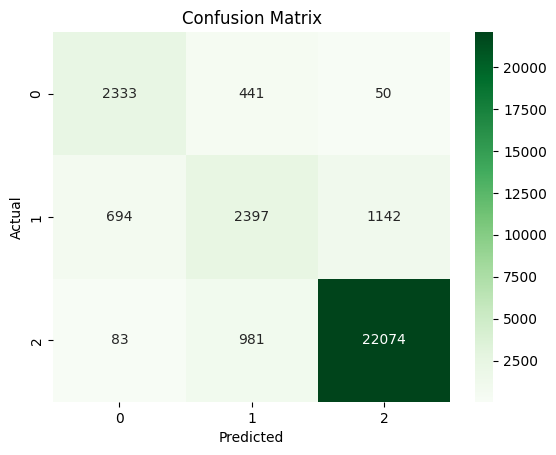

In [ ]:
#Print accuracy
accuracy = accuracy_score(correct_labels, predictions)
print("Accuracy: ", accuracy)

#Get confusion matrix
confusion = confusion_matrix(correct_labels, predictions)
print("Confusion matrix")
print(confusion)

sns.heatmap(confusion, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

#Get classification report
report = classification_report(correct_labels,predictions)
print("Classification: ")
print(report)